In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, MaxPool2D, Conv1D, LSTM, Conv2D
import pickle
from sklearn.metrics import roc_auc_score, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the combined shots data

with open('Combined_Data_Train.pkl', 'rb') as f:
    data_train = pickle.load(f)
    
with open('Combined_Data_Test.pkl', 'rb') as f:
    data_test = pickle.load(f)
    
with open('Combined_Data_CV.pkl', 'rb') as f:
    data_cv = pickle.load(f)

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## Model Creation and Training

In [4]:
class cosine_similarity(tf.keras.layers.Layer):
    
    def __init__(self):
        super(cosine_similarity, self).__init__()
        self.conv1 = Conv1D(128, (2), data_format='channels_first', padding='same')
        
    def call(self, x):
        x1, x2 = tf.split(x, 2, 1)
        
        cv1 = self.conv1(x1)
        cv2 = self.conv1(x2)
        cs = tf.keras.layers.dot( [cv1, cv2],axes=2)
        cs = tf.add(cs[:,1], cs[:,2])
        
        return cs

In [5]:
class BNet(tf.keras.layers.Layer):
    '''Boundary Net as Mentioned in the Paper'''
    def __init__(self):
        super(BNet, self).__init__()
        self.conv1 = Conv1D(128, (4), data_format='channels_first', padding='same')        
        self.maxpool = MaxPool2D((128,1),1)#, data_format='channels_last')  # same
        self.cos = cosine_similarity()
        self.lstm1 = LSTM(128, return_sequences=True)
        self.lstm2 = LSTM(128, return_sequences=True)
        self.dense1 = Dense(64, activation='relu', kernel_initializer='he_normal')
        self.dense2 = Dense(1, activation='sigmoid') 
        
    def call(self, x, feat):
        
        x1 = tf.reshape(x, (-1, 1, x.shape[1]))
        cv1 = self.conv1(x1)
        cv2 = tf.reshape(cv1, (-1, cv1.shape[1], 1, cv1.shape[2]))
        m1 = self.maxpool(cv2)
        m1 = tf.reshape(m1, (-1, m1.shape[3]))
        
        cosine_sim = self.cos(cv1)
        
        concat = tf.concat([m1, cosine_sim], axis=1)
        concat_reshape = tf.reshape(concat, (-1, 1, concat.shape[1])) 
        
        if feat == 'place':
            lstm_output = self.lstm1(concat_reshape)
        else:
            lstm_output = self.lstm2(concat_reshape)

        fc1 = self.dense1(lstm_output)

        fc2 = self.dense2(fc1)

        fc2 = tf.reshape(fc2, (-1,1))
        
        return fc2

In [6]:
class LGSS(tf.keras.layers.Layer):
    def __init__(self):
        super(LGSS, self).__init__()
        self.bnet_place = BNet()
        self.bnet_cast = BNet()
        self.bnet_action = BNet()
        self.bnet_audio = BNet()
    def call(self, place_feat, cast_feat, action_feat, audio_feat):
        
        output = 0
      #  print('\nPlace Feature')
        p_bnet = self.bnet_place(place_feat, 'place')
        output += 0.5*p_bnet
     #   print('\nCast Feature')
        c_bnet = self.bnet_place(cast_feat, 'cast')
        output += 0.2*c_bnet
    #    print('\nAction Feature')
        ac_bnet = self.bnet_action(action_feat, 'action')
        output += 0.2*ac_bnet
   #     print('\nAudio Feature')
        a_bnet = self.bnet_audio(audio_feat, 'audio')
        output += 0.1*a_bnet
        
        return output

In [7]:
class Local_to_Global_Model(tf.keras.Model):
    def __init__(self):
        super(Local_to_Global_Model, self).__init__()
        self.lgss = LGSS()
    
    def call(self, data):
        place_features = data[0]
        cast_features = data[1]
        action_features = data[2]
        audio_features = data[3]
        
        output = self.lgss(place_features, cast_features, action_features, audio_features)
        
        return output

In [8]:
LGSS_model = Local_to_Global_Model()

In [9]:
class scoring(tf.keras.callbacks.Callback):
    '''Callback to calculate AUC score for each epoch'''
    def __init__(self, validation_data):
        self.data = validation_data[:4]
        self.labels = validation_data[4]
    def on_train_begin(self, logs={}):
      #  self.f1=0
        self.auc=0
    def on_epoch_end(self, epoch, logs={}):
        
        predictions = self.model.predict(self.data)
        #y_val = self.validation_data[1]
        self.auc = roc_auc_score(self.labels, predictions)
        
        print("  AUC: {}".format(self.auc))

In [36]:
AUC = scoring(data_cv)

# saves the model after each epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint('Weights_Model1/model_log_m1_{epoch:02d}.h5', save_weights_only=True)

# reduces learning rate if the val_loss doesn't improve
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1,min_lr = 1E-5)

In [11]:
optimizer = tf.keras.optimizers.Adam(0.0001)
LGSS_model.compile(optimizer=optimizer, loss='binary_crossentropy')

In [21]:
LGSS_model.fit(data_train[:4], data_train[4], batch_size=32, epochs=10, verbose=1,
              validation_data=(data_cv[:4], data_cv[4]),
              callbacks=[AUC, checkpoint, lr_schedule])

Train on 98434 samples, validate on 4268 samples
Epoch 1/10
98434/98434 [==============================] - 141s 1ms/sample - loss: 0.2682 - val_loss: 0.2348
Epoch 2/10
98434/98434 [==============================] - 134s 1ms/sample - loss: 0.2601 - val_loss: 0.2291
Epoch 3/10
98434/98434 [==============================] - 132s 1ms/sample - loss: 0.2535 - val_loss: 0.2258
Epoch 4/10
98434/98434 [==============================] - 132s 1ms/sample - loss: 0.2519 - val_loss: 0.2252
Epoch 5/10
98434/98434 [==============================] - 132s 1ms/sample - loss: 0.2508 - val_loss: 0.2270
Epoch 6/10
98434/98434 [==============================] - 132s 1ms/sample - loss: 0.2494 - val_loss: 0.2238
Epoch 7/10
98434/98434 [==============================] - 132s 1ms/sample - loss: 0.2482 - val_loss: 0.2233
Epoch 8/10
98434/98434 [==============================] - 134s 1ms/sample - loss: 0.2473 - val_loss: 0.2219
Epoch 9/10
98434/98434 [==============================] - 133s 1ms/sample - loss: 0.246

In [13]:
#LGSS_model.load_weights('Weights_Model1/model_log_m1_10.h5')

## Evaluation

In [31]:
preds = LGSS_model.predict(data_test[:4])  # predicting labels for test data

In [33]:
def evaluate(predictions, threshold):
    lst = []
    for i in predictions:
        if i > threshold:
            lst.append(1)
        else:
            lst.append(0)
    return lst

Text(0.5, 15.0, 'Predicted')

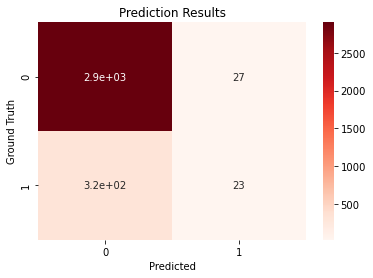

In [34]:
plt.title('Prediction Results')
sns.heatmap(confusion_matrix(data_test[4], evaluate(preds, 0.2)), annot=True, cmap='Reds')
plt.ylabel('Ground Truth')
plt.xlabel('Predicted')